### Libraries

In [154]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

#Lema
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

#nlp count
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

### Load Data

In [155]:
query = "Query_AI-magazines-mediacloud-2021-24"

FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)

df.shape[0]

2633

In [156]:
df['media_name'].value_counts()

media_name
wired.com               929
technologyreview.com    770
theverge.com            468
theatlantic.com         339
medium.com              109
thespectrum.com          18
Name: count, dtype: int64

In [157]:
df = df[df['media_name'] == 'technologyreview.com'] # Filter by magazine
df = df.reset_index(drop=True)

df.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG
600,d14c4cb3a3a988bfa9aaa9dbd913356427071d4ba84bac...,2024-05-08 09:33:53.657984,en,technologyreview.com,technologyreview.com,2022-06-13,The Download: Marseille’s surveillance fightba...,https://www.technologyreview.com/2022/06/13/10...,2022,The Download: Marseille’s surveillance fightba...,True,"[Marseille, Marseille, China, London, New Delh...","[Emmanuel Macron, Fleur Macdonald, Sheryl Sand...","[Digital, the city council, Google, Google, MI..."


### Clean Data

In [158]:
df.columns

Index(['id', 'indexed_date', 'language', 'media_name', 'media_url',
       'publish_date', 'title', 'url', 'year', 'text', 'text_downloaded',
       'GPE', 'IND', 'ORG'],
      dtype='object')

### Lematization

In [159]:
nlp = spacy.load("en_core_web_sm")

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.7.6). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [160]:
# df['text_clean'] = df['title'] + ' ' + df['text'] 
df['text_clean'] = df['text'] 

In [161]:
df['text_clean']

0      2024 Innovator of the Year: Shawn Shan builds ...
1      What impact will AI have on video game develop...
2      To be more useful, robots need to become lazie...
3      Roblox is launching a generative AI that build...
4      Sponsored\nIntegrating security from code to c...
                             ...                        
765                                                     
766                                                     
767    Sponsored\nThese five AI developments will sha...
768                                                     
769    This avocado armchair could be the future of A...
Name: text_clean, Length: 770, dtype: object

In [162]:
# Calcula la cantidad de palabras por fila
df["word_count"] = df["text_clean"].apply(lambda x: len(x.split()))

In [163]:
df.text[1]

'What impact will AI have on video game development?\nIt could make working conditions more bearable—or it could just put people out of work.\nThis story is from The Algorithm, our weekly newsletter on AI. To get it in your inbox first, sign up here.\nVideo game development has long been plagued by fear of the “crunch”—essentially, being forced to work overtime on a game to meet a deadline. In the early days of video games, the crunch was often viewed as a rite of passage: In the last days before release, an obsessed group of scrappy developers would work late into the night to perfect their dream game.\nHowever, nowadays the crunch is less likely to be glamorized than to be seen as a form of exploitation that risks causing mental illness and burnout. Part of the issue is that crunch time used to be just before a game launched, but now whole game development periods are “crunchy.” With games getting more expensive, companies are incentivized to make even more short-term profits by sque

In [164]:
# Parsing

def parse_document(text):
    """
    Parses the text using spaCy.
    Returns a processed spaCy document.
    """
    return nlp(text)


df['parsed_doc'] = df['text_clean'].apply(parse_document)



In [165]:
df['parsed_doc']

0      (2024, Innovator, of, the, Year, :, Shawn, Sha...
1      (What, impact, will, AI, have, on, video, game...
2      (To, be, more, useful, ,, robots, need, to, be...
3      (Roblox, is, launching, a, generative, AI, tha...
4      (Sponsored, \n, Integrating, security, from, c...
                             ...                        
765                                                   ()
766                                                   ()
767    (Sponsored, \n, These, five, AI, developments,...
768                                                   ()
769    (This, avocado, armchair, could, be, the, futu...
Name: parsed_doc, Length: 770, dtype: object

In [166]:
# Calcula la cantidad de palabras por fila

# Custom words to remove
CUSTOM_STOP_WORDS = {'ai', 'say', 'year', 'way', 'use', 'need', 'technology', 'tech', 'mit', 'review'}

# Function to clean tokens
def clean_tokens(doc):
    """
    Cleans tokens from the parsed document:
    - Filters tokens by POS tags: PROPN, NOUN, and optionally VERB.
    - Uses lemmatized forms (lemma_) instead of original text.
    - Excludes stopwords, punctuation, and custom-defined words.
    """
    tokens = [
        token.lemma_ for token in doc
        # if token.pos_ in {"PROPN", "NOUN", "VERB"}  # Keep specific POS tags
        if token.pos_ in {"PROPN", "NOUN"}  # Keep specific POS tags
        and token.text.lower() not in STOP_WORDS    # Exclude stopwords
        and token.is_alpha                          # Keep only alphabetic tokens
        # and token.text.lower() not in string.punctuation  # Exclude punctuation
        and token.text.lower() not in CUSTOM_STOP_WORDS # Exclude custom-defined words
    ]
    return tokens


df['parsed_lemmas'] = df['parsed_doc'].apply(lambda doc: ' '.join(clean_tokens(doc)))

# df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))

df['parsed_lemmas'].iloc[0]

'Innovator Shawn Shan tool artist Shan Glaze Nightshade tool artist copyright Shawn Shan innovator rest honoree image model DALL E Midjourney Diffusion kick boom artist similarity image work data set model knockoff style work client tool image artist rate artist tool Shawn Shan phd student computer science University Chicago Innovator Shan start security privacy undergraduate project Fawkes tool face recognition conversation artist boom middle fight field impact artist Shan advisor Ben Zhao innovator list Heather Zheng list tool input artist Shan algorithm Glaze tool artist style mimicry glaze October Shan team tool Nightshade layer poison image image model image data set poison machine model training datum model output algorithm change pixel image machine model response Glaze Shan team backlash booster medium attempt protection artist glaze time Nightshade art platform Cara artist protection work image Glaze paper award Internet Defense Prize Usenix Security Symposium computer securit

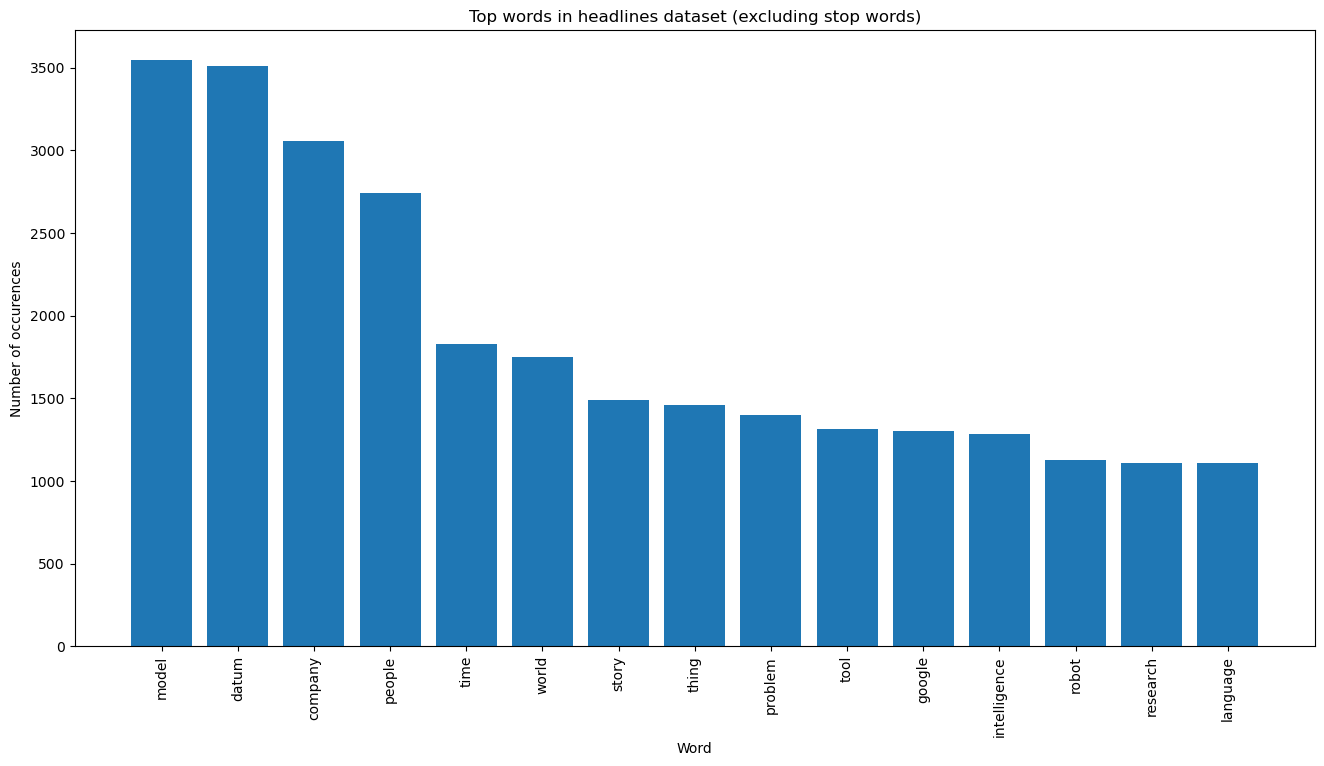

In [167]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['parsed_lemmas'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Save clean text

In [168]:
df.to_csv('Query_AI_text_clean.csv', index=False)

### Analysis

In [169]:
df = pd.read_csv('Query_AI_text_clean.csv')

In [170]:
df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,text_clean,word_count,parsed_doc,parsed_lemmas
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,2024 Innovator of the Year: Shawn Shan builds ...,941,2024 Innovator of the Year: Shawn Shan builds ...,Innovator Shawn Shan tool artist Shan Glaze Ni...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,What impact will AI have on video game develop...,1366,What impact will AI have on video game develop...,impact video game development working conditio...
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,"To be more useful, robots need to become lazie...",1772,"To be more useful, robots need to become lazie...",robot Smarter datum processing machine energy ...


In [171]:
df.shape

(770, 18)

In [173]:
df['parsed_lemmas'].isnull().sum()

180

In [174]:
# df = df.dropna(subset=['clean_text'])

### Temperature

In [175]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color
247,76d5459a7931a972451bfffb41aa34da2997e0f936d4f4...,2024-02-16 15:19:46.018998,en,technologyreview.com,technologyreview.com,2023-11-16,Google DeepMind wants to define what counts as...,https://www.technologyreview.com/2023/11/16/10...,2023,Google DeepMind wants to define what counts as...,True,['UK' 'AI'],['Julian Togelius' 'Shane Legg' 'Legg' 'Legg' ...,['Google DeepMind' 'Google DeepMind' 'Google D...,Google DeepMind wants to define what counts as...,1232,Google DeepMind wants to define what counts as...,Google DeepMind intelligence AGI concept resea...,1,#5500aa
123,6642204a01873ccba184212e6fb96acd1a53b7816d65a4...,2024-05-10 16:19:03.005100,en,technologyreview.com,technologyreview.com,2024-05-10,AI systems are getting better at tricking us,https://www.technologyreview.com/2024/05/10/10...,2024,AI systems are getting better at tricking us\n...,True,[],['Cicero' 'Cicero' 'Cicero' 'Cicero' 'Cicero' ...,['AI' 'Meta' 'Meta' 'Meta' 'Meta' 'AlphaStar' ...,AI systems are getting better at tricking us\n...,1002,AI systems are getting better at tricking us\n...,system deception goal wave system human way ex...,2,#0000ff
147,8cf119652db4515f9b25d0a5f863e4a4619558e6a5d905...,2024-04-12 04:53:23.792215,en,technologyreview.com,technologyreview.com,2024-04-10,Generative AI can turn your most precious memo...,https://www.technologyreview.com/2024/04/10/10...,2024,Generative AI can turn your most precious memo...,True,['Barcelona' 'Spain' 'Barcelona' 'Greece' 'Syr...,['Maria' 'Maria' 'Francisco Franco' 'Maria' 'P...,['Synthetic Memories' 'Domestic Data Streamers...,Generative AI can turn your most precious memo...,1514,Generative AI can turn your most precious memo...,Generative memory photo Synthetic Memories pro...,2,#0000ff


In [176]:
df.shape

(770, 20)

In [178]:
# df = df.dropna(subset=['year'])
# df = df.dropna(subset=['clean_text'])

In [179]:
df.shape

(770, 20)

In [180]:
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,2024 Innovator of the Year: Shawn Shan builds ...,941,2024 Innovator of the Year: Shawn Shan builds ...,Innovator Shawn Shan tool artist Shan Glaze Ni...,2,#0000ff
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,What impact will AI have on video game develop...,1366,What impact will AI have on video game develop...,impact video game development working conditio...,2,#0000ff
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,"To be more useful, robots need to become lazie...",1772,"To be more useful, robots need to become lazie...",robot Smarter datum processing machine energy ...,2,#0000ff
3,6e756b42d864508050ba087a650179d05ac91be0b4855d...,2024-09-06 18:23:28.427532,en,technologyreview.com,technologyreview.com,2024-09-06,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,True,['France' 'Paris'],['Marcus Holmström' 'GPT-4' 'Roblox' 'Anupam S...,['The Gang' 'Roblox' 'AI' 'Roblox' 'AI' 'Kent ...,Roblox is launching a generative AI that build...,972,Roblox is launching a generative AI that build...,Roblox environment snap game environment platf...,2,#0000ff
4,3ac10c795421811068dff2c020f48849fad908cb32cb47...,2024-09-05 15:28:38.006311,en,technologyreview.com,technologyreview.com,2024-09-05,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,True,['withMicrosoft' 'Jiankui'],['David Harmon' 'Vlad Korsunsky' 'Harmon' 'Fle...,['AMD' 'The Human Genome Project' 'SpaceX' 'Te...,Sponsored\nIntegrating security from code to c...,1482,Sponsored\nIntegrating security from code to c...,Integrating security code today source softwar...,2,#0000ff


In [181]:
df["word_count"]

0       941
1      1366
2      1772
3       972
4      1482
       ... 
765       0
766       0
767    1540
768       0
769    1273
Name: word_count, Length: 770, dtype: int64

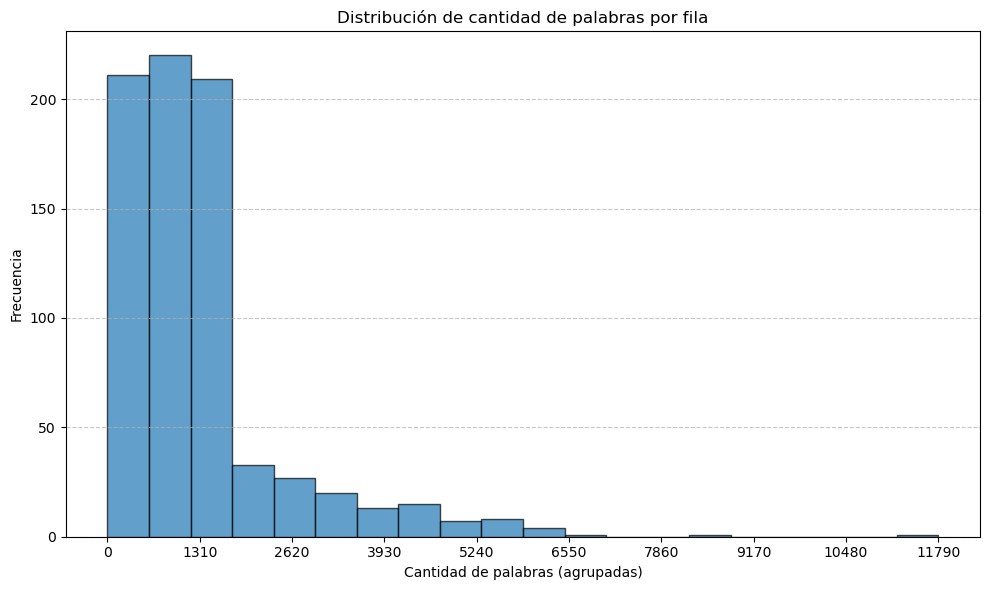

In [182]:
# Genera un histograma con ajustes
plt.figure(figsize=(10, 6))
plt.hist(df["word_count"], bins=20, edgecolor="black", alpha=0.7)  # Ajusta bins a 20 intervalos
plt.title("Distribución de cantidad de palabras por fila")
plt.xlabel("Cantidad de palabras (agrupadas)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Ajuste de ticks en el eje X
plt.xticks(np.linspace(df["word_count"].min(), df["word_count"].max(), 10).astype(int))
plt.tight_layout()
plt.show()

In [183]:
# Filtrar filas donde word_count <= 20
df = df[df["word_count"] >= 10]


### Term Frequency

In [185]:
# df["clean_text"]

In [186]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["parsed_lemmas"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,2024 Innovator of the Year: Shawn Shan builds ...,941,2024 Innovator of the Year: Shawn Shan builds ...,Innovator Shawn Shan tool artist Shan Glaze Ni...,2,#0000ff
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,What impact will AI have on video game develop...,1366,What impact will AI have on video game develop...,impact video game development working conditio...,2,#0000ff
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,"To be more useful, robots need to become lazie...",1772,"To be more useful, robots need to become lazie...",robot Smarter datum processing machine energy ...,2,#0000ff


## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/cc/r8jrc5vs4wx2fz86qn6nrz0h0000gn/T/ipykernel_7400/236189347.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
/var/folders/cc/r8jrc5vs4wx2fz86qn6nrz0h0000gn/T/ipykernel_7400/236189347.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

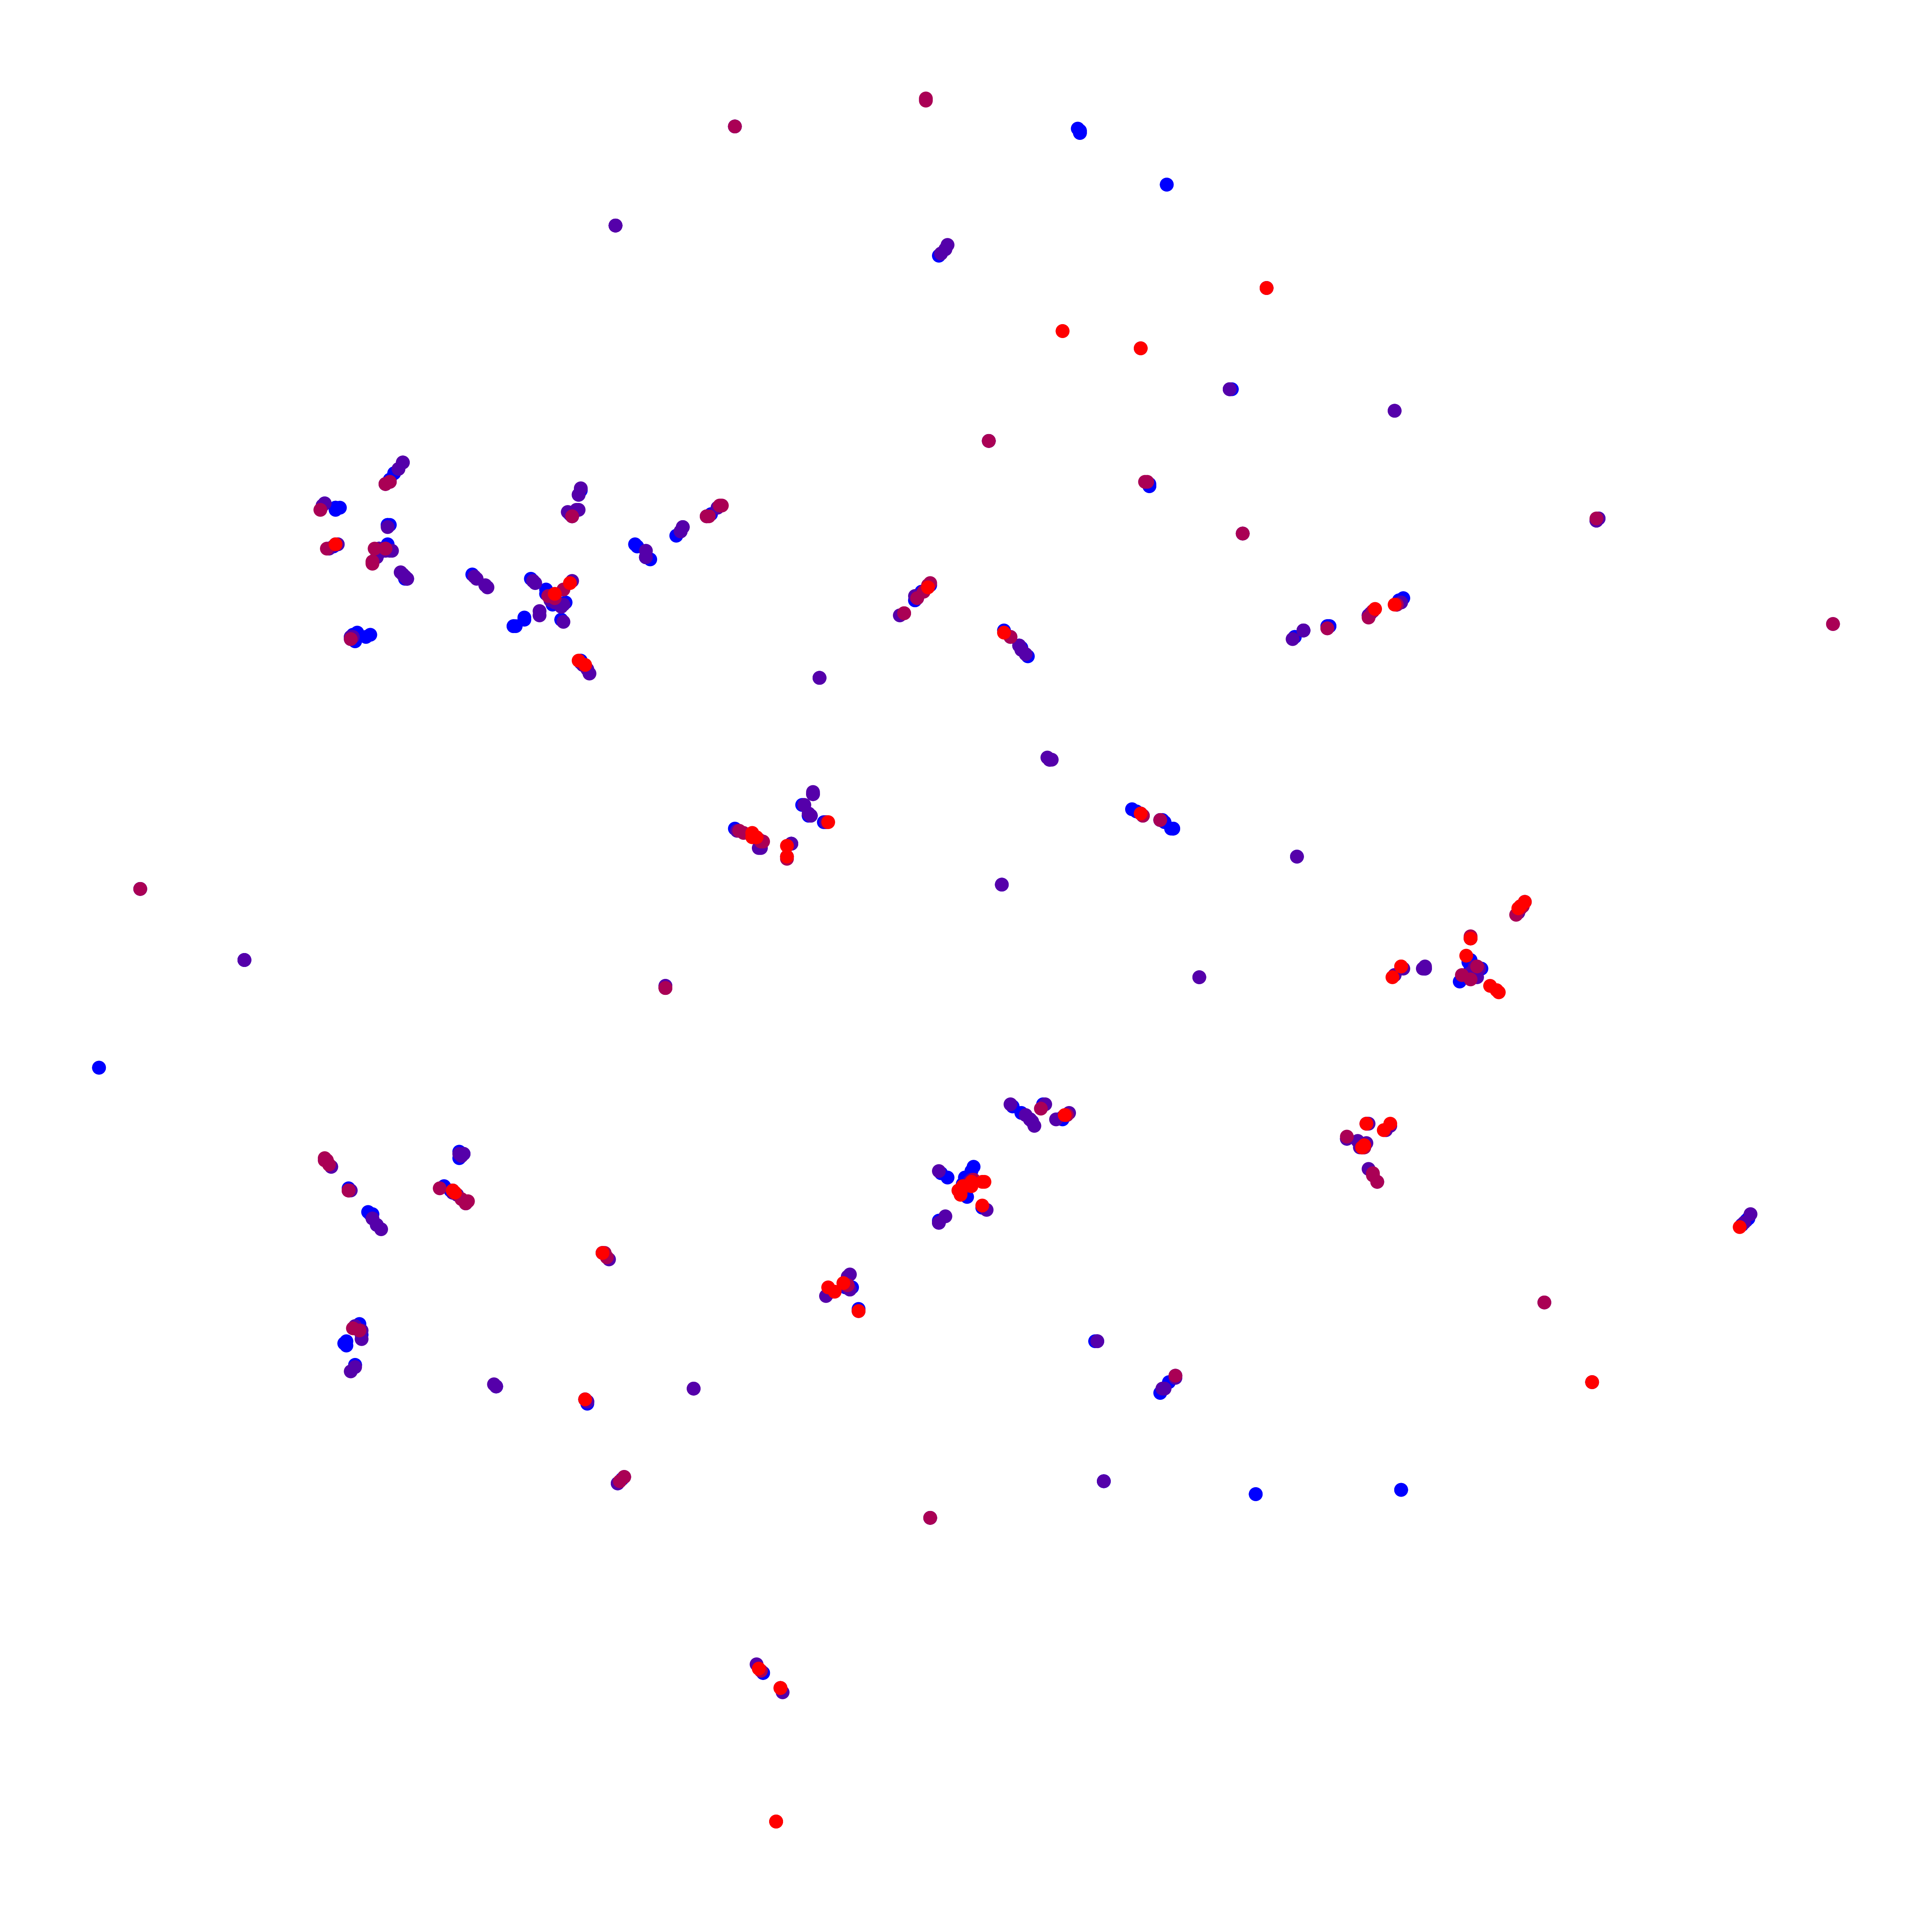

In [187]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=2,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

# embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")

## Clustering

In [188]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=10,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=10,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    # cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

/var/folders/cc/r8jrc5vs4wx2fz86qn6nrz0h0000gn/T/ipykernel_7400/2699649629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = "-1"  # Reset


,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster
203,5343d7ed7558cb7fa73c5336b3f143fbf98d104fb2a654...,2024-01-19 08:16:55,en,technologyreview.com,technologyreview.com,2024-01-17,Four things to know about China’s new AI rules...,https://www.technologyreview.com/2024/01/17/10...,2024,Four things to know about China’s new AI rules...,...,['AI' 'China Report' 'MIT Technology Review' '...,Four things to know about China’s new AI rules...,1513,Four things to know about China’s new AI rules...,thing China rule law zooming copyright safety ...,2,#0000ff,366.0,697.0,p_10
306,635e05f1ca7433c09e3d05d50b7e6313773e8007b6595f...,2024-02-20 22:24:41.631714,en,technologyreview.com,technologyreview.com,2023-09-19,Deepfakes of Chinese influencers are livestrea...,https://www.technologyreview.com/2023/09/19/10...,2023,Deepfakes of Chinese influencers are livestrea...,...,['Taobao' 'Taobao' 'Douyin' 'Reddit' 'Silicon ...,Deepfakes of Chinese influencers are livestrea...,1822,Deepfakes of Chinese influencers are livestrea...,deepfake influencer minute sample video brand ...,1,#5500aa,385.0,710.0,-1
154,73f498868e25cd7e89f8c2f5ef8e069cd508a8cd78c253...,2024-04-10 04:58:20.862753,en,technologyreview.com,technologyreview.com,2024-04-08,Tackling AI risks: Your reputation is at stake,https://www.technologyreview.com/2024/04/08/10...,2024,Sponsored\nTackling AI risks: Your reputation ...,...,['AI' 'AI' 'AI' 'the Responsible Technology Pl...,Sponsored\nTackling AI risks: Your reputation ...,1149,Sponsored\nTackling AI risks: Your reputation ...,risk reputation stake risk context technology ...,2,#0000ff,666.0,655.0,p_2


{'n_1', 'p_8', 'p_17', '-1', 'p_5', 'p_7', 'p_11', 'p_0', 'n_5', 'p_14', 'p_10', 'p_9', 'p_3', 'p_16', 'n_3', 'p_12', 'p_2', 'n_0', 'p_15', 'p_1', 'p_6', 'n_2', 'p_4', 'n_4', 'p_13'}


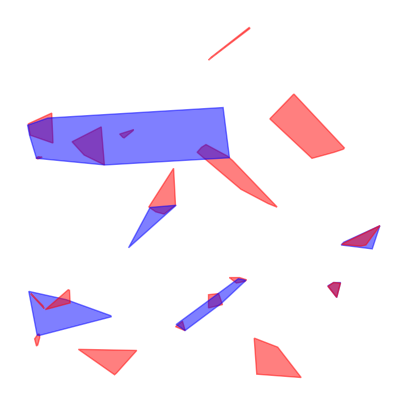

In [189]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [190]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster
271,bec084064180643b3a5e447fdf19a50f7215d9b1c94678...,2024-02-18 12:04:22.503977,en,technologyreview.com,technologyreview.com,2023-10-23,This new data poisoning tool lets artists figh...,https://www.technologyreview.com/2023/10/23/10...,2023,This new data poisoning tool lets artists figh...,...,['AI' 'Nightshade' 'MIT Technology Review' 'Us...,This new data poisoning tool lets artists figh...,1275,This new data poisoning tool lets artists figh...,data poisoning tool artist tool Nightshade tra...,1,#5500aa,488.0,828.0,p_0


# Explorin the clusters

In [191]:
df['cluster'].value_counts()

cluster
-1      116
p_17     39
p_16     35
n_2      33
p_8      32
p_2      30
p_12     25
p_7      25
n_1      20
p_5      19
n_4      19
n_5      19
p_11     18
p_14     17
p_4      17
p_1      14
p_6      14
p_10     13
p_13     13
p_9      13
n_3      13
p_3      13
p_0      11
p_15     11
n_0      11
Name: count, dtype: int64

In [192]:
df['cluster'].nunique()

25

In [193]:
import random

In [206]:
# Filter the headlines belonging to cluster 
cluster_id = 'p_4'
cluster_headlines = df[df['cluster'] == cluster_id]['parsed_lemmas']

# Randomly select 10 headlines (or less if there aren't enough) with the seed directly in the same line
random_headlines = random.Random(0).sample(cluster_headlines.tolist(), min(20, len(cluster_headlines)))

# Convert the list of headlines into a string to pass to the API
headlines_text = "\n".join(random_headlines)
print(headlines_text)

test creativity language model creativity test creativity study Scientific report today chatbot score human Alternate Uses Task test ability study fuel debate researcher computer test human finding ai ability ai creativity test research understanding human machine task researcher chatbot OpenAI ChatGPT Copy use rope box pencil candle second prompt language model use item quality idea quantity chatbot time object researcher participant instruction researcher method response algorithm object object purpose assessor answer system response scale term score human ai chatbot response human response purpose study system human role question characteristic human Simone Grassini professor psychology University Bergen Norway research year leap behavior model machine task creativity human thought Ryan Burnell research associate Alan Turing Institute research chatbot box datum response model idea thing training datum Alternate use Task case creativity model knowledge kind task machine human problem

In [195]:
df['color'].value_counts()

color
#5500aa    225
#0000ff    209
#aa0055     95
#ff0000     61
Name: count, dtype: int64

In [196]:
#Filter by colour

selected_color = '#ff0000'
unique_clusters = df.loc[df['color'] == selected_color, 'cluster'].unique()
if unique_clusters.size > 0:
    print(f"The unique clusters for color {selected_color} are: {list(unique_clusters)}")
else:
    print(f"Color {selected_color} not found in the dataset.")


The unique clusters for color #ff0000 are: ['n_2', 'n_4', 'n_3', 'n_1', 'n_0', '-1', 'n_5']
